In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [24]:
df = pd.read_csv('C:\\Users\\User\\source\\repos\\BIHF\\flat_files\\advertisements_202006112147.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_5760\4206964124.py:1: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Users\\User\\source\\repos\\BIHF\\flat_files\\advertisements_202006112147.csv')


In [25]:
df['production'] = pd.to_datetime(df['production'])

In [26]:
df.set_index('production', inplace=True)

In [27]:
df["Day.Of.Year.X"], df["Day.Of.Year.Y"] = np.sin(2 * np.pi * df.index.day_of_year / 365), np.cos(2 * np.pi * df.index.day_of_year / 365)

In [28]:
df["ad_price"] = pd.to_numeric(df["ad_price"], errors="coerce")
df = df.dropna(subset=["ad_price"])

In [29]:
df

,ad_id,region_id,ad_price,numpictures,proseller,adoldness,postalcode,mileage,clime_id,gas_id,...,upload_date,description,advertisement_url,catalog_url,sales_date,is_sold,download_date,sales_update_date,Day.Of.Year.X,Day.Of.Year.Y
production,,,,,,,,,,,,,,,,,,,,,
1997-12-01,1545570,5,530000,5,False,4584,5600,244000,3,NaN,...,2007-10-07,NaN,NaN,no catalog,NaN,False,2020-04-25,2020-04-25,-0.493776,0.869589
2005-12-01,4066033,13,1290000,6,False,3509,2671,148000,4,NaN,...,2010-08-11,NaN,NaN,http://katalogus.hasznaltauto.hu/opel/astra_1....,NaN,False,2020-03-20,2020-03-20,-0.493776,0.869589
1994-11-01,4109007,4,580000,6,False,3526,6000,181900,2,NaN,...,2010-08-30,NaN,NaN,http://katalogus.hasznaltauto.hu/saab/900_2.5_...,NaN,False,2020-04-25,2020-04-25,-0.858764,0.512371
2005-09-01,4246385,9,1450000,6,False,3435,4033,185000,2,NaN,...,2010-10-25,NaN,NaN,http://katalogus.hasznaltauto.hu/seat/leon_1.4...,NaN,False,2020-03-21,2020-03-21,-0.871706,-0.490029
1900-01-01,5440448,15,9990000,6,False,3022,8600,98500,5,NaN,...,2012-01-17,NaN,NaN,http://katalogus.hasznaltauto.hu/mercedes-benz...,NaN,False,2020-04-26,2020-04-26,0.017213,0.999852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-05-01,15726818,6,5250000,12,True,0,6728,201500,4,NaN,...,2020-05-06,NaN,NaN,http://katalogus.hasznaltauto.hu/audi/q5_2.0_t...,NaN,False,2020-05-06,2020-05-06,0.871706,-0.490029
2016-04-01,15726825,3,5300000,12,True,0,1154,129711,5,NaN,...,2020-05-06,NaN,NaN,http://katalogus.hasznaltauto.hu/volkswagen/go...,NaN,False,2020-05-06,2020-05-06,0.999917,-0.012910
2010-05-01,15726904,3,4990000,12,True,0,1152,140000,5,NaN,...,2020-05-06,NaN,NaN,http://katalogus.hasznaltauto.hu/audi/a5_cabri...,NaN,False,2020-05-06,2020-05-06,0.871706,-0.490029


**Splitting, Scaling, and Sequence Handling**

In [30]:
input_cols = [
    "numpictures", "adoldness", "postalcode",
    "mileage", "clime_id"
]

target_col = "ad_price"

train_start = pd.Timestamp("2010")
valid_start = pd.Timestamp("2014")
test_start = pd.Timestamp("2016")
train_df = df[(df.index >= train_start) & (df.index < valid_start)].copy()
valid_df = df[(df.index >= valid_start) & (df.index < test_start)].copy()
test_df = df[(df.index >= test_start)].copy()

In [31]:
scaler_input = StandardScaler()
scaler_output = StandardScaler()

scaled_train = scaler_input.fit_transform(train_df[input_cols])
target_train = scaler_output.fit_transform(train_df[[target_col]])

scaled_valid = scaler_input.transform(valid_df[input_cols])
target_valid = scaler_output.transform(valid_df[[target_col]])

scaled_test = scaler_input.transform(test_df[input_cols])
target_test = scaler_output.transform(test_df[[target_col]])

In [32]:
def process_Xy(raw_X: np.array, raw_y: np.array, lookback: int) -> np.array:
        X = np.empty(shape=(raw_X.shape[0] - lookback, lookback , raw_X.shape[1]), dtype=np.float32)
        y = np.empty(shape=(raw_y.shape[0] - lookback), dtype=np.float32)

        target_index = 0
        for i in range(lookback, raw_X.shape[0]):
            X[target_index] = raw_X[i - lookback : i]
            y[target_index] = raw_y[i]
            target_index += 1

        return X.copy(), y.copy()

In [33]:
lookback = 10
train_X, train_y = process_Xy(scaled_train, target_train, lookback=lookback)
valid_X, valid_y = process_Xy(scaled_valid, target_valid, lookback=lookback)
test_X, test_y = process_Xy(scaled_test, target_test, lookback=lookback)

C:\Users\User\AppData\Local\Temp\ipykernel_5760\916063004.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[target_index] = raw_y[i]


**Model Building, Training, Validating, Testing, and Visualizing**

In [34]:
model = keras.Sequential(
    [
        layers.LSTM(16, activation="relu", input_shape = train_X.shape[1:]),
        layers.Dense(1),
    ]
)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
model.compile(loss='MeanSquaredError', optimizer='Adam')

In [36]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 16)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,425 (5.57 KB)

 Trainable params: 1,425 (5.57 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
callbacks = [EarlyStopping(monitor="val_loss", patience=10)]

In [38]:
history = model.fit(
            train_X,
            train_y,
            validation_data=(valid_X, valid_y),
            batch_size=16,
            epochs=100,
            callbacks=callbacks,
            shuffle=True,
            verbose=True,
        )

Epoch 1/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.0299 - val_loss: 3.7760
Epoch 2/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.0222 - val_loss: 3.6929
Epoch 3/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.9612 - val_loss: 3.7202
Epoch 4/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.9693 - val_loss: 3.6274
Epoch 5/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9876 - val_loss: 3.6154
Epoch 6/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.9992 - val_loss: 3.5423
Epoch 7/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.9235 - val_loss: 3.5255
Epoch 8/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.9047 - val_loss: 3.5728
Epoch 9/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.0703 - val_loss: 3.5974
Epoch 10/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.9131 - val_loss: 3.6148
Epoch 11/100
405/405 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.9845 - val_loss: 3.6138
Epoch 12/100
405/405 ━━━━━━━━━━━━━━━━━━━━

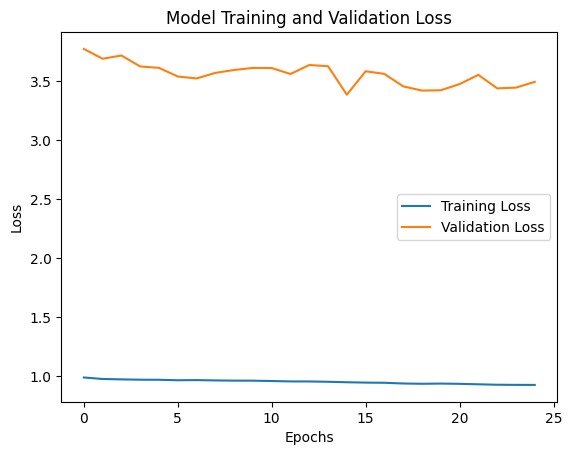

In [39]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
actual_prices = scaler_output.inverse_transform(test_y.reshape(-1, 1)).flatten()
predicted_prices = scaler_output.inverse_transform(pred).flatten()

aligned_index = test_df.index[lookback:]

results_df = pd.DataFrame({
    "Date": aligned_index,
    "Actual": actual_prices,
    "Predicted": predicted_prices
}).set_index("Date")

results_df = results_df.resample('M').mean()

C:\Users\User\AppData\Local\Temp\ipykernel_5760\1404062871.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  results_df = results_df.resample('M').mean()


180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


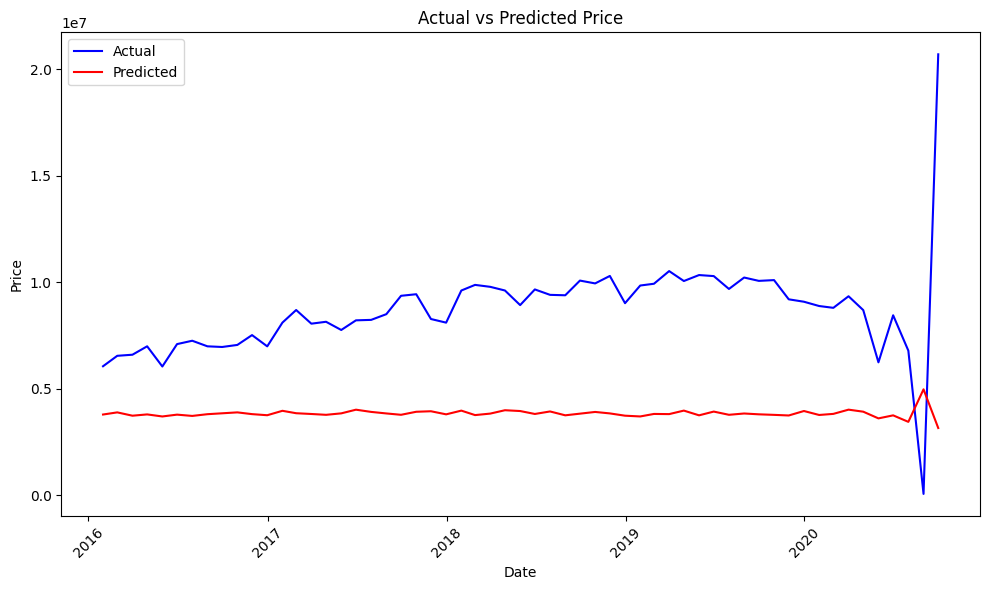

In [51]:
pred = model.predict(test_X)
plt.figure(figsize=(10, 6))
plt.plot(results_df["Actual"], label='Actual', color='blue')
plt.plot(results_df["Predicted"], label='Predicted', color='red')
plt.xticks(rotation=45)
plt.title('Actual vs Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()